In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt           
import cv2
import tensorflow as tf                
from tqdm import tqdm
from IPython.display import FileLink
from sklearn.utils import class_weight

In [2]:
train_dir = 'C:/Users/SUNNY\Downloads/X-ray-pneunomia-Project/chest_xray/train'
test_dir = 'C:/Users/SUNNY\Downloads/X-ray-pneunomia-Project/chest_xray/test'
val_dir = 'C:/Users/SUNNY\Downloads/X-ray-pneunomia-Project/chest_xray/val'

In [9]:
img = cv2.imread(train_dir + '/' + 'NORMAL/' + 'IM-0128-0001.jpeg')
img.shape

(1013, 1528, 3)

In [13]:
normal_train_images = len(os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0])))
normal_train_images

1341

In [14]:
pneumonia_train_images = len(os.listdir(os.path.join(train_dir, os.listdir(train_dir)[1])))
pneumonia_train_images

3875

<BarContainer object of 2 artists>

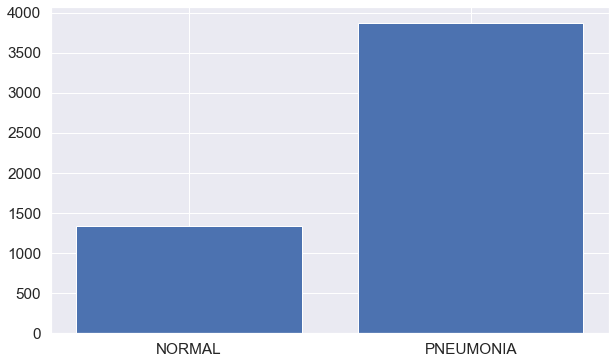

In [15]:
class_name = ['NORMAL', 'PNEUMONIA']
actual_numbers = [normal_train_images, pneumonia_train_images]
plt.figure(figsize = (10,6))
plt.bar(class_name, actual_numbers)

In [16]:
pneumonia_test_images = len(os.listdir(os.path.join(test_dir, os.listdir(test_dir)[1])))
pneumonia_test_images

390

In [17]:
labels = ['NORMAL', 'PNEUMONIA']

In [18]:
batch_size = 32
img_height = 400
img_width = 400

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                              validation_split=0.2,
                                                              subset="training",
                                                              seed = 123,
                                                              image_size=(img_height,img_width),
                                                              batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16 files belonging to 2 classes.


In [61]:
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [20]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [22]:
label_name = {'NORMAL' : 0, 'PNEUMONIA' : 1}

In [24]:
class_weight = {label_name['NORMAL'] : 3, label_name['PNEUMONIA'] : 1}

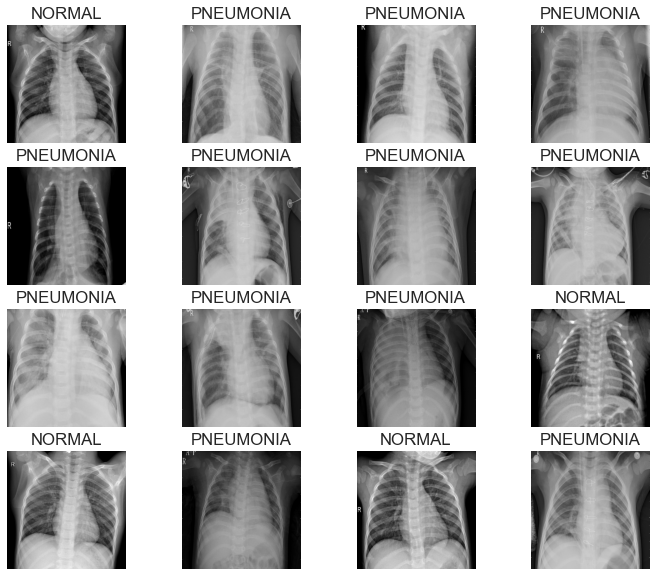

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, label_batch =  next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.039846957 0.87441266


In [33]:
data_augmentation = tf.keras.Sequential(
[
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                         input_shape = (img_height, img_width,
                                                                       3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),

    
]
)

In [37]:
model = tf.keras.Sequential([
    data_augmentation,
    normalization_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),   
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
    
])

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 400, 400, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 197, 197, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 16)       

In [39]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [44]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 100, class_weight =  class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
131/131 [==============================] - 19s 67ms/step - loss: 0.9757 - accuracy: 0.5567 - val_loss: 0.5585 - val_accuracy: 0.7147
Epoch 2/100
131/131 [==============================] - 9s 65ms/step - loss: 0.6989 - accuracy: 0.7834 - val_loss: 0.3752 - val_accuracy: 0.8446
Epoch 3/100
131/131 [==============================] - 9s 66ms/step - loss: 0.5737 - accuracy: 0.8375 - val_loss: 0.3879 - val_accuracy: 0.8253
Epoch 4/100
131/131 [==============================] - 9s 65ms/step - loss: 0.4827 - accuracy: 0.8665 - val_loss: 0.3071 - val_accuracy: 0.8798
Epoch 5/100
131/131 [==============================] - 9s 65ms/step - loss: 0.3946 - accuracy: 0.9013 - val_loss: 0.3080 - val_accuracy: 0.8782
Epoch 6/100
131/131 [==============================] - 9s 65ms/step - loss: 0.3607 - accuracy: 0.9061 - val_loss: 0.2912 - val_accuracy: 0.87

Epoch 55/100
131/131 [==============================] - 9s 65ms/step - loss: 0.2017 - accuracy: 0.9478 - val_loss: 0.3999 - val_accuracy: 0.8766
Epoch 56/100
131/131 [==============================] - 9s 64ms/step - loss: 0.2046 - accuracy: 0.9530 - val_loss: 0.4193 - val_accuracy: 0.8878
Epoch 57/100
131/131 [==============================] - 9s 65ms/step - loss: 0.1950 - accuracy: 0.9573 - val_loss: 0.4885 - val_accuracy: 0.8590
Epoch 58/100
131/131 [==============================] - 9s 64ms/step - loss: 0.1898 - accuracy: 0.9538 - val_loss: 0.3650 - val_accuracy: 0.8846
Epoch 59/100
131/131 [==============================] - 9s 65ms/step - loss: 0.1876 - accuracy: 0.9561 - val_loss: 0.4731 - val_accuracy: 0.8702
Epoch 60/100
131/131 [==============================] - 9s 65ms/step - loss: 0.1910 - accuracy: 0.9538 - val_loss: 0.4981 - val_accuracy: 0.8670
Epoch 61/100
131/131 [==============================] - 9s 65ms/step - loss: 0.1961 - accuracy: 0.9535 - val_loss: 0.4495 - val_ac

In [45]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

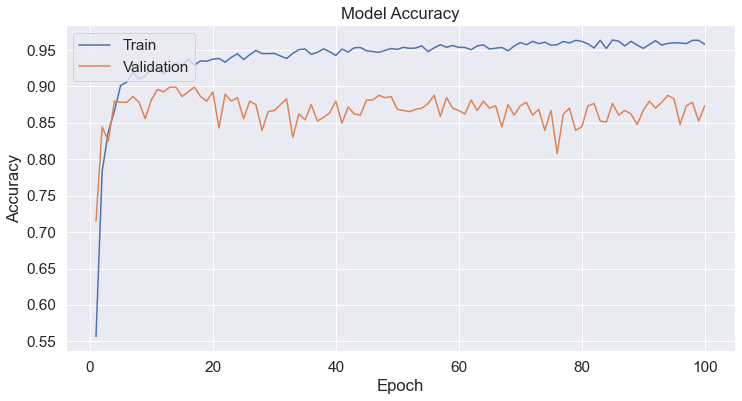

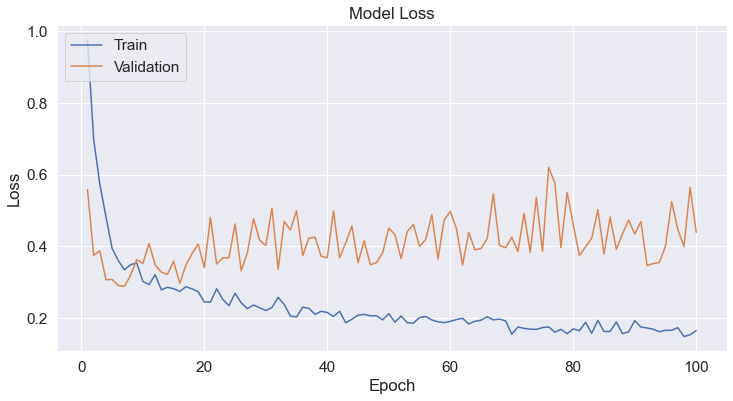

In [47]:
plotLearningCurve(history, 100)

In [73]:
model.evaluate(test_ds)


20/20 [==============================] - 1s 46ms/step - loss: 0.4392 - accuracy: 0.8734


[0.4391559064388275, 0.8733974099159241]